In [6]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../../icenumerics/')
sys.path.insert(0, '../auxnumerics/')
sys.path.insert(0, '..')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
from parameters import params
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [7]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [9]:
os.getcwd()

'/home/frieren/Documents/projects/stuckgs/src/mkfig'

In [10]:
datasmol = '/media/frieren/BIG/stuckgs/data/sims/10'
databig = '/media/frieren/BIG/stuckgs/data/sims/30'

In [14]:
def do_vertices_shit(data_path):
    vrt_path = os.path.join(data_path,"vertices/")
    vertices = aux.getVerticesDict(vrt_path)
    counts = aux.getVerticesCount(vertices)
    vrt_ts = aux.getVerticesAverage(counts,params["framespersec"])
    types = vrt_ts.columns.to_list()[1:]
    t = vrt_ts["time"].to_numpy()
    vrt_counts = vrt_ts[types].to_numpy()
    return t, vrt_counts

# Vertices average expanded types

In [37]:
def get_vertices_from_realization(data_path,r=1):
    # importing vertices
    vrt_path = os.path.join(data_path,'vertices')
    vertices = pd.read_csv(os.path.join(vrt_path,f'vertices{r}.csv'))
    vertices[['dx','dy']] = np.around(vertices[['dx','dy']])
    
    # classify the vertices
    vertices = aux.classify_vrt_expanded(vertices)
    return ice.count_vertices(vertices)

In [122]:
# getting a dictionary with the vertices counts
counts_dict = {i:get_vertices_from_realization(databig,r=i) for i in range(1,10+1)}

# this is simply concatenating the columns in a single dataframe so that i can average columsn
complete_fractions = pd.concat([counts_dict[i].fraction for i in range(1,10+1)],axis=1)
vertices_average = complete_fractions.mean(axis=1)

In [123]:
pd.DataFrame(vertices_average,columns=['fraction']).to_csv(os.path.join(databig,'recount_expanded.csv'))

In [136]:
vrt_av = pd.DataFrame(vertices_average,columns=['fraction'])
vrt_av.xs('I',level='type')


,fraction
frame,
0,0.062291
10,0.063626
20,0.062180
30,0.063849
40,0.061624
...,...
8350,0.178643
8360,0.178643
8370,0.179088


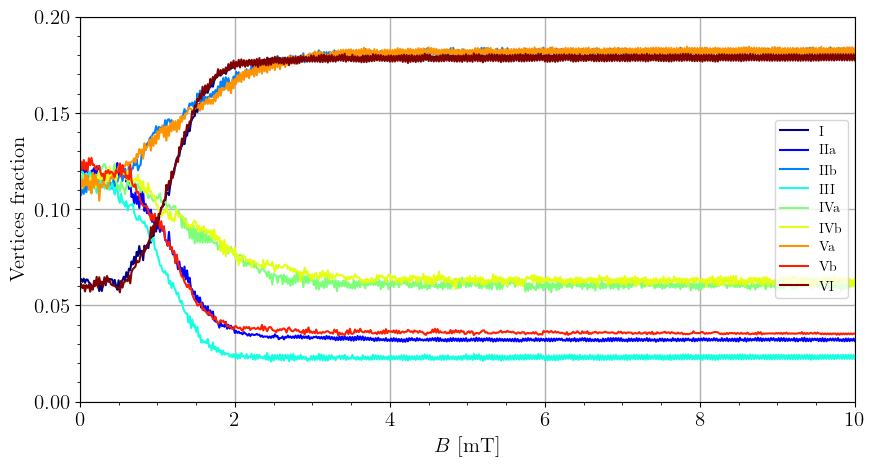

In [137]:
fig, ax = plt.subplots(figsize=(10,5))
cmap = plt.get_cmap('jet')
colors = [cmap(i /8) for i in range(9) ]

types = ['I', 'IIa', 'IIb', 'III', 'IVa', 'IVb', 'Va', 'Vb', 'VI'] 
mapping = {tp:c for c,tp in zip(colors,types)}

for tp in types:
    
    ts = vrt_av.xs(tp,level='type').fraction
    field = ts.index.get_level_values('frame').unique().to_numpy()/20 * 10/300
    ax.plot(field,ts.to_numpy(),label=tp, c=mapping[tp])

ax.set_xlim(0,10)
ax.set_xlabel('$B$ [mT]',fontsize=15)

ax.set_ylim(0,0.2)
ax.set_ylabel('Vertices fraction', fontsize=15)

ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())


ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_formatter(plt.NullFormatter())


ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(True, which='major', linewidth = 1)
ax.minorticks_on()

#plt.legend(types)
plt.legend()
plt.show()

## Usual vertices average

In [4]:
vrt_path = os.path.join(datasmol,"vertices/")
vertices = aux.getVerticesDict(vrt_path)
counts = aux.getVerticesCount(vertices)

In [5]:
good_frames = counts['10'].index.get_level_values('frame').unique().to_list()


In [45]:
for r,experiment in counts.items():
    cur_counts = experiment.loc[idx[good_frames,:]]
    cur_counts['realization'] = [int(r)]*len(cur_counts)
    
    if int(r)==1:
        cur_counts.to_csv('../data/sims/10/counts.csv')
    else:
        cur_counts.to_csv('../data/sims/10/counts.csv',mode='a',header=False)
    

# A bit messy, but lets go back

In [6]:
csmall = pd.read_csv(os.path.join(datasmol,'counts.csv'), index_col=['realization','frame','type'])
cbig = pd.read_csv(os.path.join(databig,'counts.csv'), index_col=['realization','frame','type'])

In [7]:
csmallav = pd.DataFrame()
cbigav = pd.DataFrame()

In [8]:
for vtype, dftype in csmall.groupby('type'):
    
    typeall = [singlertype.fraction.to_list() for r, singlertype in dftype.groupby('realization')]
    csmallav[vtype] = np.array(typeall).mean(axis=0)
        

In [9]:
for vtype, dftype in cbig.groupby('type'):
    
    typeall = [singlertype.fraction.to_list() for r, singlertype in dftype.groupby('realization')]
    cbigav[vtype] = np.array(typeall).mean(axis=0)

In [44]:
time = [i for i in range(len(csmallav))]
field = [10/300*ti for ti in time]

In [25]:
cmap = plt.get_cmap('plasma')
colors = [cmap(i /3) for i in range(4) ]

gsmall = [
    csmallav['I'] + csmallav['VI'],
    csmallav['II'] +csmallav['V'],
    csmallav['IV'],
    csmallav['III']
]

gbig = [
    cbigav['I'] + cbigav['VI'],
    cbigav['II'] +cbigav['V'],
    cbigav['IV'],
    cbigav['III']
]

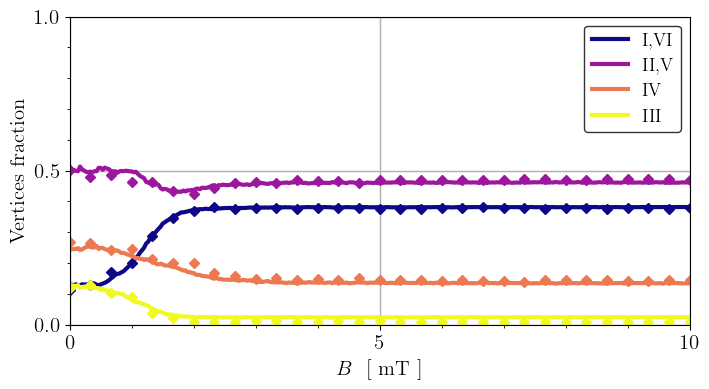

In [67]:
fig, ax = plt.subplots(figsize=(8,4))

types = ['I,VI','II,V','IV','III']

for i in range(4):
        ax.plot(field, gbig[i], color = colors[i], linewidth=3, label = types[i])
        ax.plot(field[::10], gsmall[i][::10], 'D', color = colors[i], markersize=5)

ax.legend(fontsize=13,edgecolor='black')

ax.set_xlim(0,10)
ax.set_ylim(0,1)

ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.xaxis.set_minor_formatter(plt.NullFormatter())


ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_formatter(plt.NullFormatter())


ax.set_ylabel('Vertices fraction', fontsize=15)
ax.set_xlabel("$B$ \,\,[ mT ] ", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(True, which='major', linewidth = 1)
ax.minorticks_on()

plt.show()

fig.savefig('../data/figs/fig2.pdf', bbox_inches='tight')
fig.savefig('../data/figs/fig2.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(8,4))

ax = axes[0]
ax.plot(field,csmallav['I'] + csmallav['VI'])
ax.plot(field,csmallav['II'] +csmallav['V'] )
ax.plot(field,csmallav['III'])
ax.plot(field,csmallav['IV'])

ax.set_xlim(0,10)
ax.set_ylim(0,0.6)
ax.set_xticklabels([])
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid()

ax = axes[1]
ax.plot(field,cbigav['I'] + cbigav['VI'])
ax.plot(field,cbigav['II'] +cbigav['V'] )
ax.plot(field,cbigav['III'])
ax.plot(field,cbigav['IV'])

ax.set_xlim(0,10)
ax.set_ylim(0,0.6)
ax.set_xlabel("$B$ \,\,[ mT ] ", fontsize=15)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid()



#ax.legend(types, fontsize=12,title='Type', title_fontsize=15, edgecolor='black')
fig.text(0.05,0.5,
         'Vertices counts',
         horizontalalignment='center',
         verticalalignment='center',
         rotation='vertical',
         fontsize=15)
fig.legend(types,
        ncol=6,
        fontsize=12,
        edgecolor='black',
        loc=('upper center')
        )
plt.show()

fig.savefig('../data/figs/fig2.pdf', bbox_inches='tight')
fig.savefig('../data/figs/fig2.png', dpi=300, bbox_inches='tight')